<a href="https://colab.research.google.com/github/Usmaelabdureman/ML/blob/main/FinalProjectMammodata.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Final Project
Course Name: Artificial Intelligence for Biomedical Eng’g

Course Code: BMED-4291

### **Name:** Abdulhefiz Abdurahman
### **ID:** UGR/9715/12

### Instruction
1. Make sure you are using a version of Anaconda with python 3.
2. Once you are done, submit your answers to this email address `end21am@gmail.com`
3. The deadline for submmision is May 18, 2023

## Predict whether a mammogram mass is benign or malignant

We'll be using the "mammographic masses" public dataset from the UCI repository (source: https://archive.ics.uci.edu/ml/datasets/Mammographic+Mass)

This data contains 961 instances of masses detected in mammograms, and contains the following attributes:


   1. BI-RADS assessment: 1 to 5 (ordinal)  
   2. Age: patient's age in years (integer)
   3. Shape: mass shape: round=1 oval=2 lobular=3 irregular=4 (nominal)
   4. Margin: mass margin: circumscribed=1 microlobulated=2 obscured=3 ill-defined=4 spiculated=5 (nominal)
   5. Density: mass density high=1 iso=2 low=3 fat-containing=4 (ordinal)
   6. Severity: benign=0 or malignant=1 (binominal)
   
BI-RADS is an assesment of how confident the severity classification is; it is not a "predictive" attribute and so we will discard it. The age, shape, margin, and density attributes are the features that we will build our model with, and "severity" is the classification we will attempt to predict based on those attributes.

Although "shape" and "margin" are nominal data types, which sklearn typically doesn't deal with well, they are close enough to ordinal that we shouldn't just discard them. The "shape" for example is ordered increasingly from round to irregular.

A lot of unnecessary anguish and surgery arises from false positives arising from mammogram results. If we can build a better way to interpret them through supervised machine learning, it could improve a lot of lives.

## Your assignment

Apply several different supervised machine learning techniques to this data set, and see which one yields the highest accuracy as measured with K-Fold cross validation (K=10). Apply:

* Decision tree
* Random forest
* KNN
* Naive Bayes
* SVM
* Logistic Regression

The data needs to be cleaned; many rows contain missing data, and there may be erroneous data identifiable as outliers as well.

Remember some techniques such as SVM also require the input data to be normalized first.

Many techniques also have "hyperparameters" that need to be tuned. Once you identify a promising approach, see if you can make it even better by tuning its hyperparameters.

I was able to achieve over 80% accuracy - can you beat that?

Below I've set up an outline of a notebook for this project, with some guidance and hints. If you're up for a real challenge, try doing this project from scratch in a new, clean notebook!


## Let's begin: prepare your data

Start by importing the mammographic_masses.data.txt file into a Pandas dataframe (hint: use read_csv) and take a look at it.

In [ ]:
# import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


### Read the dataset into a Pandas DataFrame:

In [ ]:
mass = pd.read_csv('mammographic_masses.data')

In [ ]:
mass.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 960 entries, 0 to 959
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   5       960 non-null    object
 1   67      960 non-null    object
 2   3       960 non-null    object
 3   5.1     960 non-null    object
 4   3.1     960 non-null    object
 5   1       960 non-null    int64 
dtypes: int64(1), object(5)
memory usage: 45.1+ KB


Make sure you use the optional parmaters in read_csv to convert missing data (indicated by a ?) into NaN, and to add the appropriate column names (BI_RADS, age, shape, margin, density, and severity):

In [ ]:
mass = pd.read_csv('mammographic_masses.data',
                   na_values = '?',
                   names = ['BI_RADS','age','shape','margin','density','severity'])

Evaluate whether the data needs cleaning; your model is only as good as the data it's given. Hint: use describe() on the dataframe.

In [ ]:
mass.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
BI_RADS,959.0,4.348279,1.783031,0.0,4.0,4.0,5.0,55.0
age,956.0,55.487448,14.480131,18.0,45.0,57.0,66.0,96.0
shape,930.0,2.721505,1.242792,1.0,2.0,3.0,4.0,4.0
margin,913.0,2.796276,1.566546,1.0,1.0,3.0,4.0,5.0
density,885.0,2.910734,0.380444,1.0,3.0,3.0,3.0,4.0
severity,961.0,0.463059,0.498893,0.0,0.0,0.0,1.0,1.0


In [ ]:
mass.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 961 entries, 0 to 960
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   BI_RADS   959 non-null    float64
 1   age       956 non-null    float64
 2   shape     930 non-null    float64
 3   margin    913 non-null    float64
 4   density   885 non-null    float64
 5   severity  961 non-null    int64  
dtypes: float64(5), int64(1)
memory usage: 45.2 KB


In [ ]:
mass['severity'].value_counts()

severity
0    516
1    445
Name: count, dtype: int64

There are quite a few missing values in the data set. Before we just drop every row that's missing data, let's make sure we don't bias our data in doing so. Does there appear to be any sort of correlation to what sort of data has missing fields? If there were, we'd have to try and go back and fill that data in.

In [ ]:
def percent_missing(df):
    percent_nan = df.isna().mean() * 100
    percent_nan = percent_nan[percent_nan > 0].sort_values()
    return percent_nan


Text(0, 0.5, '% missing')

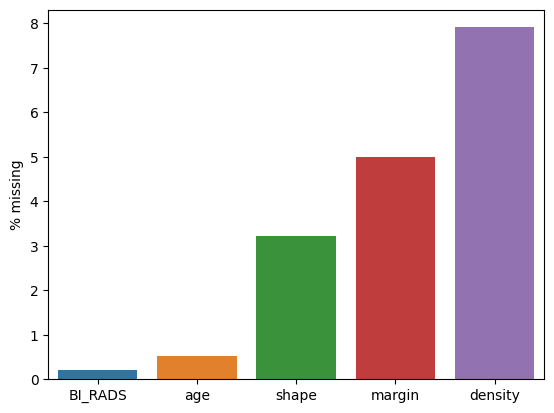

In [ ]:
percent_nan = percent_missing(mass)
sns.barplot(x=percent_nan.index,y=percent_nan)
plt.ylabel('% missing')

In [ ]:
mass[(mass['age'].isnull())|
     (mass['shape'].isnull()) |
     (mass['margin'].isnull()) |
     (mass['density'].isnull())]

,BI_RADS,age,shape,margin,density,severity
1,4.0,43.0,1.0,1.0,NaN,1
4,5.0,74.0,1.0,5.0,NaN,1
5,4.0,65.0,1.0,NaN,3.0,0
6,4.0,70.0,NaN,NaN,3.0,0
7,5.0,42.0,1.0,NaN,3.0,0
...,...,...,...,...,...,...
778,4.0,60.0,NaN,4.0,3.0,0
819,4.0,35.0,3.0,NaN,2.0,0
824,6.0,40.0,NaN,3.0,4.0,1
884,5.0,NaN,4.0,4.0,3.0,1


In [ ]:
mass.isnull().sum()

BI_RADS      2
age          5
shape       31
margin      48
density     76
severity     0
dtype: int64

If the missing data seems randomly distributed, go ahead and drop rows with missing data. Hint: use dropna().

In [ ]:
# drop rows with missing values
mass.dropna(inplace=True)

In [ ]:
mass.isnull().sum()

BI_RADS     0
age         0
shape       0
margin      0
density     0
severity    0
dtype: int64

Next you'll need to convert the Pandas dataframes into numpy arrays that can be used by scikit_learn. Create an array that extracts only the feature data we want to work with (age, shape, margin, and density) and another array that contains the classes (severity). You'll also need an array of the feature name labels.

In [ ]:
# convert dataframe to numeric
X = mass.drop(['severity','BI_RADS'],axis=1)
y = mass['severity']

Some of our models require the input data to be normalized, so go ahead and normalize the attribute data. Hint: use preprocessing.StandardScaler().

In [ ]:
# import necessary libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


## Decision Trees

Before moving to K-Fold cross validation and random forests, start by creating a single train/test split of our data. Set aside 75% for training, and 25% for testing.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=101)
scaler = StandardScaler()
scaled_X_train = scaler.fit_transform(X_train)
scaled_X_test = scaler.transform(X_test)

Now create a DecisionTreeClassifier and fit it to your training data.

In [ ]:
# import Decision tree classifier
from sklearn.tree import DecisionTreeClassifier

dtc = DecisionTreeClassifier(random_state=101)
dtc.fit(scaled_X_train,y_train)

DecisionTreeClassifier(random_state=101)

Display the resulting decision tree.

In [ ]:
dtc_pred = dtc.predict(scaled_X_test)

Measure the accuracy of the resulting decision tree model using your test data.

In [ ]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay

In [ ]:
confusion_matrix(y_test,dtc_pred)

array([[81, 27],
       [31, 69]])

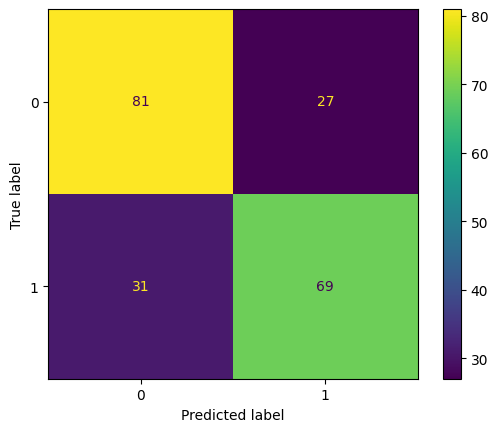

In [ ]:

cm = confusion_matrix(y_test, dtc_pred)

# Display the confusion matrix
cmd = ConfusionMatrixDisplay(cm)
cmd.plot()

In [ ]:
print(classification_report(y_test,dtc_pred))

              precision    recall  f1-score   support

           0       0.72      0.75      0.74       108
           1       0.72      0.69      0.70       100

    accuracy                           0.72       208
   macro avg       0.72      0.72      0.72       208
weighted avg       0.72      0.72      0.72       208



In [ ]:
accuracy_score(y_test,dtc_pred)

0.7211538461538461

In [ ]:
dtc.feature_importances_

array([0.36889498, 0.09596899, 0.50018325, 0.03495278])

Now instead of a single train/test split, use K-Fold cross validation to get a better measure of your model's accuracy (K=10). Hint: use model_selection.cross_val_score

In [ ]:
from sklearn.model_selection import cross_val_score
dtc_cv_scores = cross_val_score(dtc,scaled_X_train,y_train,scoring='accuracy',cv=10)

dtc_cv_scores.mean()

0.7266769073220687

Now try a RandomForestClassifier instead. Does it perform better?

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(n_estimators=64,max_features='sqrt',random_state=101)
rfc_cv_scores = cross_val_score(rfc,scaled_X_train,y_train,scoring='accuracy',cv=10)
rfc_cv_scores.mean()

0.7378648233486944

In [ ]:
rfc.fit(scaled_X_train,y_train)

RandomForestClassifier(n_estimators=64, random_state=101)

In [ ]:
accuracy_score(y_test,rfc.predict(scaled_X_test))

0.7836538461538461

### Does it perform better?
***Yes***, RandomFroestClassifier performs better. We may try to use grid search to find out the a combination of hyperparameters to help improve the accuracy further.

In [ ]:
from sklearn.model_selection import GridSearchCV

n_estimators=[64,100,128,200]
max_features= [2,3,4]
bootstrap = [True,False]

param_grid = {'n_estimators':n_estimators,
             'max_features':max_features,
             'bootstrap':bootstrap} 

rfc = RandomForestClassifier()
rfc_grid = GridSearchCV(rfc,param_grid,cv=10)
rfc_grid.fit(scaled_X_train,y_train)

GridSearchCV(cv=10, estimator=RandomForestClassifier(),
             param_grid={'bootstrap': [True, False], 'max_features': [2, 3, 4],
                         'n_estimators': [64, 100, 128, 200]})

In [ ]:
rfc_grid.best_params_

{'bootstrap': True, 'max_features': 3, 'n_estimators': 200}

In [ ]:
rfc_grid_pred = rfc_grid.predict(scaled_X_test)
accuracy_score(y_test,rfc_grid_pred)

0.7692307692307693

## SVM

Next try using svm.SVC with a linear kernel. How does it compare to the decision tree?

In [ ]:
from sklearn.svm import SVC

In [ ]:
svc = SVC(kernel='linear',C=1.0)
svc_cv_scores = cross_val_score(svc,scaled_X_train,y_train,scoring='accuracy',cv=10)
svc_cv_scores.mean()

0.773399897593446

In [ ]:
svc.fit(scaled_X_train,y_train)


SVC(kernel='linear')

In [ ]:
accuracy_score(y_test,svc.predict(scaled_X_test))

0.8413461538461539

How does it compare to the decision tree?

####  SupportVectorMachines has better performance than the decision tree. 

## KNN
How about K-Nearest-Neighbors? Hint: use neighbors.KNeighborsClassifier - it's a lot easier than implementing KNN from scratch like we did earlier in the course. Start with a K of 10. K is an example of a hyperparameter - a parameter on the model itself which may need to be tuned for best results on your particular data set.

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()

Choosing K is tricky, so we can't discard KNN until we've tried different values of K. Write a for loop to run KNN with K values ranging from 1 to 50 and see if K makes a substantial difference. Make a note of the best performance you could get out of KNN.

In [ ]:
k_values = list(range(1,51))
param_grid = {'knn__n_neighbors':k_values}

operations = [('knn',knn)]

from sklearn.pipeline import Pipeline
pipe = Pipeline(operations)

knn_grid = GridSearchCV(pipe,param_grid,cv=10,scoring='accuracy')



In [ ]:
knn_grid.fit(scaled_X_train,y_train)

GridSearchCV(cv=10, estimator=Pipeline(steps=[('knn', KNeighborsClassifier())]),
             param_grid={'knn__n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11,
                                              12, 13, 14, 15, 16, 17, 18, 19,
                                              20, 21, 22, 23, 24, 25, 26, 27,
                                              28, 29, 30, ...]},
             scoring='accuracy')

In [ ]:
knn_grid.best_estimator_

Pipeline(steps=[('knn', KNeighborsClassifier(n_neighbors=48))])

Text(0, 0.5, 'Accuracy')

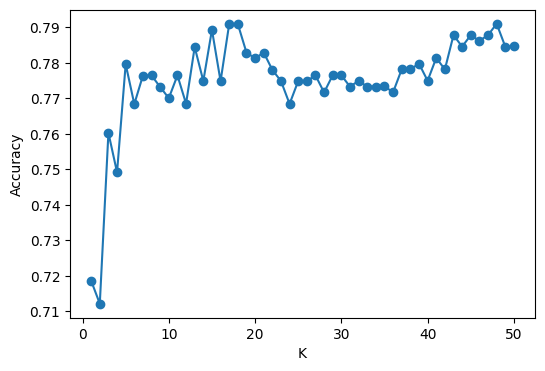

In [ ]:
plt.figure(figsize=(6,4))
plt.plot(range(1,51),knn_grid.cv_results_['mean_test_score'],marker='o')
plt.xlabel('K')
plt.ylabel('Accuracy')

In [ ]:
knn_grid_pred = knn_grid.predict(scaled_X_test)
accuracy_score(y_test,knn_grid_pred)

0.8221153846153846

## Naive Bayes

Now try naive_bayes.MultinomialNB. How does its accuracy stack up? Hint: you'll need to use MinMaxScaler to get the features in the range MultinomialNB requires.

In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import MinMaxScaler

In [ ]:
scaler = MinMaxScaler()

minmax_X_train = scaler.fit_transform(X_train)
minmax_X_test = scaler.transform(X_test)

mnb = MultinomialNB()
mnb_cv_scores = cross_val_score(mnb,minmax_X_train,y_train,cv=10)
mnb_cv_scores.mean()


0.762058371735791

In [ ]:
mnb.fit(minmax_X_train,y_train)

MultinomialNB()

In [ ]:
accuracy_score(y_test,mnb.predict(minmax_X_test))

0.8269230769230769

### Let's Revisit Support Vector Machines (SVM)
The performance of svm.SVC can vary depending on the kernel used. The selection of a kernel is considered a "hyperparameter." Experiment with the rbf, sigmoid, and poly kernels to determine the kernel that achieves the highest performance. Is there a new kernel that outperforms the others?

In [ ]:
svc = SVC()
param_grid = {'kernel':['linear','rbf','sigmoid','poly'],
             'C':[0.01,0.1,0.5,1,5,10]}

svc_grid = GridSearchCV(svc,param_grid)

svc_grid.fit(scaled_X_train,y_train)

GridSearchCV(estimator=SVC(),
             param_grid={'C': [0.01, 0.1, 0.5, 1, 5, 10],
                         'kernel': ['linear', 'rbf', 'sigmoid', 'poly']})

In [ ]:
svc_grid.best_estimator_

SVC(C=0.1, kernel='linear')

In [ ]:
svc_grid_pred = svc_grid.predict(scaled_X_test)
accuracy_score(y_test,svc_grid_pred)

0.8413461538461539

SVM with C=0.1 and linear kernel has so far the best performance. 

## Logistic Regression

Try Logisitic Regression, which is a simple way to tackling this sort of thing.

In [ ]:
from sklearn.linear_model import LogisticRegression
log = LogisticRegression(solver='saga',
                               multi_class="ovr",
                               max_iter=1000000)

In [ ]:
penalty = ['l1', 'l2']

C = np.logspace(0, 4, 10)

log_grid = GridSearchCV(log,param_grid={'C':C,'penalty':penalty},cv=5)

log_grid.fit(scaled_X_train,y_train)

GridSearchCV(cv=5,
             estimator=LogisticRegression(max_iter=1000000, multi_class='ovr',
                                          solver='saga'),
             param_grid={'C': array([1.00000000e+00, 2.78255940e+00, 7.74263683e+00, 2.15443469e+01,
       5.99484250e+01, 1.66810054e+02, 4.64158883e+02, 1.29154967e+03,
       3.59381366e+03, 1.00000000e+04]),
                         'penalty': ['l1', 'l2']})

In [ ]:
log_grid.best_estimator_

LogisticRegression(max_iter=1000000, multi_class='ovr', penalty='l1',
                   solver='saga')

In [ ]:
accuracy_score(y_test,log_grid.predict(scaled_X_test))

0.8365384615384616

## Do we have a winner?

Which model, and which choice of hyperparameters, performed the best?

### Answer:
Yes, we have a winner! It turns out that the **SVM** model performed the best, achieving an accuracy score of over **84%**. However, it's worth mentioning that the simpler model, ***logistic regression**, showed comparable performance."

The hyperparameters of the SVM model that delivered superior results were **C=0.1** (regularization parameter) and **kernel='linear'** (using a linear kernel function).